In [8]:
!pip install dpkt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.0/195.0 KB 6.4 MB/s eta 0:00:00


In [9]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive

drive.mount(ROOT)           # we mount the google drive at /content/drive

Mounted at /content/drive


In [10]:
cd /content/drive/MyDrive/22Project

/content/drive/MyDrive/22Project


# Purpose: 

With using .csv file, I have to declare multiple arrays.

To reduce memory and disk waste, I'll try to get throughput by using .pcap file

# <Step 1> Data Preprocessing : Get throughput

1. Declare time array and throughput array that will be used as x-axis and y-axis
2. Set window size as 1
3. Check if each packet's timestamp is valid in setting time

```
# for i = 0 to maximum packet's time:
    If time <= packet's timestamp < time+window:
      thruput += packet's thruput
    else:
      move time as packet's timestamp and keep on comparing
```


  #     Dispute Point

1. big size of .pcap file -> takes long time to parsing.
- solution : split .pcap file to small size .pcap files.

2. To parse .pcap file, which module you'll use? 
- dpkt module ~ fatster, simple to use
- scapy module ~ slower, flexible


In [11]:
from sklearn.model_selection import train_test_split # To seperate train set and test set
from sklearn.linear_model import LinearRegression # To use linear regression

# For polynomial regression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

# For LSTM model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# For ARIMA model

import dpkt # for parsing .pcap file
import numpy as np # for linear algebra
import matplotlib.pyplot as plt # to show data scatter, pgraph
import seaborn as sns
%matplotlib inline

In [12]:
timeArr = np.array([]) # Will be used as x-axis
throughputArr = np.array([]) # Will be used as y-axis

window = 1 # window size will be 1[sec] / for each window, read pcap file and check the throughput at that time

In [13]:
# get last packet's time in pcap file 
first_ts = 1668940204
filename = "dataset_1126pcap.pcap" # Open the file (pcap)
last_ts = 0
with open(filename, "rb") as f:
  pcap = dpkt.pcap.Reader(f)
  for ts, buf in pcap: # n = the number of packets // O(n)
    eth = dpkt.ethernet.Ethernet(buf)
    last_ts = ts

print(f"first timestamp: {first_ts}, last timestamp: {last_ts}")

first timestamp: 1668940204, last timestamp: 1668949467.840286


In [14]:
import math
captured_time = first_ts # first captured time

with open(filename, "rb") as f:
  pcap = dpkt.pcap.Reader(f)
  total_size = 0
  for ts, buf in pcap:
    eth = dpkt.ethernet.Ethernet(buf) # eth will be used to get size of the packet's
    if captured_time <= ts < captured_time + window: # 만약 해당 pkt의 ts가 captured_time과 captured_time+window 사이라면
      total_size += len(eth) # 해당 throughput을 저장

    else: # If packet's timestamp is bigger than captured time,
      timeArr = np.append(timeArr, captured_time) # Store time information in array
      throughputArr = np.append(throughputArr, total_size) # Store throughput information in array

      captured_time = math.floor(ts) # change captured_time as that packet's time
      total_size = len(eth) # store packet's thruput

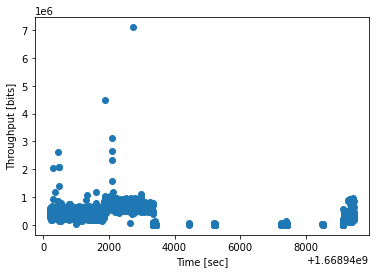

In [105]:
plt.xlabel('Time [sec]')
plt.ylabel('Throughput [bits]')
plt.scatter(timeArr, throughputArr)

---

# <Step 2> Traffic Prediction based on chart using ML

**Traffic Estimation ⇒ Supervised Model**

▶ Reason : We can know throughputs (results) in .pcap file

---

# (1) Polynomial Regression model

**Quadratic equation**

In [80]:
# Seperate train set and test set from data
# train set : 80%
# test set : 20%
train_input, test_input, train_target, test_target = train_test_split(
    timeArr, throughputArr, test_size=0.2, random_state=42)

# To use polynomial regression, input array has to be 2D.
train_input = train_input.reshape(-1, 1)
test_input = test_input.reshape(-1, 1)

print(f"the number of train data: {train_input.shape[0]}\nthe number of test data : {test_input.shape[0]}")

the number of train data: 2917
the number of test data : 730


In [81]:
# degree = 2 인 2차 다항식으로 변환하기 위해 PolynomialFeatures를 이용하여 변환
poly = PolynomialFeatures(include_bias=False)

train_poly = poly.fit_transform(train_input)
test_poly = poly.transform(test_input)

lr = LinearRegression()
lr.fit(train_poly, train_target)

print(f"Coefficient: {lr.coef_}\n\nIntercept: {lr.intercept_}")

Coefficient: [ 5.06708940e+07 -1.51805212e-02]

Intercept: -4.228345418263315e+16


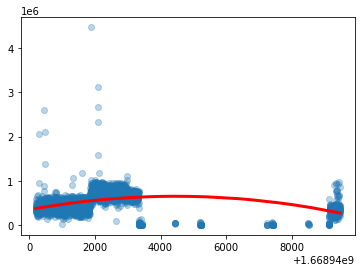

In [82]:
xs = np.arange(first_ts,last_ts+1) # To determine range of x that will be shown
ys = xs*lr.coef_[0] + (xs**2)*lr.coef_[1] + lr.intercept_ 
# model y = coef[0]*x^2 + coef[1]*x + intercept

plt.scatter(train_input, train_target, alpha=0.3)
plt.plot(xs,ys,'r-',lw=3)

In [84]:
train_target

array([7.32352e+05, 6.40846e+05, 8.82677e+05, ..., 2.03373e+05,
       3.26767e+05, 2.74000e+02])

In [19]:
print(lr.score(train_poly, train_target))
print(lr.score(test_poly, test_target))

0.16403986281936045
0.09449549145805847


**5th degree equation**

In [20]:
poly = PolynomialFeatures(degree=5, include_bias=False)
poly.fit(train_input)
train_poly = poly.transform(train_input)
test_poly = poly.transform(test_input)
print(train_poly.shape)

(2917, 5)


In [21]:
lr5 = LinearRegression()
lr5.fit(train_poly, train_target) 

print(f"Coefficient: {lr5.coef_}\n\nIntercept: {lr5.intercept_}")

Coefficient: [ 5.86201870e-49 -1.30623326e-30  2.44918856e-30  2.72503927e-21
 -1.30623364e-30]

Intercept: -4228343972241984.0


**Dispute Point**

> Polynomial function can be close to the dataset x.

> But It has limit because there are so many inputs.

> So accuracy can't be high


---



# (2) LSTM model (Long Short-Term Memory)

In [106]:
# Store in memory x(t) to x(t+4)
time_steps = 5

# Data preprocessing -> To use LSTM, I need an array that has throughput that fit in range 5
# About thruput
x_train_throughput = []
y_train_throughput = []
for i in range(len(throughputArr) - time_steps):
  x_train_throughput.append(throughputArr[i:i+time_steps])
  y_train_throughput.append(throughputArr[i+time_steps])

# x_train_throughput --> y_train_throughput
x_train_throughput = np.array(x_train_throughput)
y_train_throughput = np.array(y_train_throughput)

# Make as 3D array
x_train_throughput = np.reshape(x_train_throughput, (x_train_throughput.shape[0], x_train_throughput.shape[1], 1))

# Seperate the data in test set and train set
# train : test = 8 : 2
train_input, test_input, train_target, test_target = train_test_split(
    x_train_throughput, y_train_throughput, test_size=0.2, shuffle = False)

# Will be used as x-axis (time)
# train_time : 8, test_time : 2
split_idx = int(len(x_train_throughput) * 0.8)
train_time = []
for i in range(len(timeArr) - time_steps):
    train_time.append(timeArr[i:i+time_steps])

train_time = np.array(train_time)
train_time, test_time = train_time[:split_idx], train_time[split_idx:]

# Define the LSTM model
model = Sequential() # Create neural network model
model.add(LSTM(50, activation='relu', input_shape=(time_steps, 1))) 
# Add layer with 50 units / Activation Function: ReLU

# Sigmoid : output in the range of 0 to 1. Where output is binary or Where the prediction involves a probability
# Tanh : range of -1 to 1. Where data has negative values
# Softmax : multi-class classification problems. Where the output is a set of probabilities that sum up to 1

model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the LSTM model
model.fit(x_train_throughput, y_train_throughput, epochs=100, batch_size=1)

# Use the LSTM model to make predictions on new data
# Make test throughput array as 3D
test_input = np.reshape(test_input, (test_input.shape[0], test_input.shape[1], 1))
y_pred = model.predict(test_input)
print(y_pred)  # This will output the predicted throughput for the next time step

Epoch 1/100
3642/3642 [==============================] - 13s 3ms/step - loss: 41980481536.0000
Epoch 2/100
3642/3642 [==============================] - 11s 3ms/step - loss: 40833974272.0000
Epoch 3/100
3642/3642 [==============================] - 9s 3ms/step - loss: 39330365440.0000
Epoch 4/100
3642/3642 [==============================] - 11s 3ms/step - loss: 38029545472.0000
Epoch 5/100
3642/3642 [==============================] - 11s 3ms/step - loss: 38478249984.0000
Epoch 6/100
3642/3642 [==============================] - 10s 3ms/step - loss: 37058342912.0000
Epoch 7/100
3642/3642 [==============================] - 10s 3ms/step - loss: 37228490752.0000
Epoch 8/100
3642/3642 [==============================] - 11s 3ms/step - loss: 40810655744.0000
Epoch 9/100
3642/3642 [==============================] - 11s 3ms/step - loss: 40361451520.0000
Epoch 10/100
3642/3642 [==============================] - 9s 3ms/step - loss: 37828550656.0000
Epoch 11/100
3642/3642 [===========================

In [117]:
y_pred_1d = y_pred.flatten()
test_time_1d = timeArr[int(len(timeArr)*0.8+1):]
print(f"len of y_pred: {len(y_pred_1d)}, len of test_time: {len(test_time_1d)}")

len of y_pred: 729, len of test_time: 729


In [115]:
len(timeArr)*0.8+1

2918.6000000000004

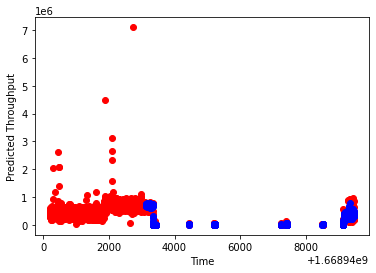

In [120]:
plt.xlabel("Time")
plt.ylabel('Predicted Throughput')
plt.scatter(timeArr, throughputArr, color='red', label='True')
plt.scatter(test_time_1d, y_pred_1d, color='blue', label='Predicted')